In [12]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GitHub/ERA-V1/Assignments/S10

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/ERA-V1/Assignments/S10


In [17]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), 818 bytes | 24.00 KiB/s, done.
From https://github.com/selvaraj-sembulingam/ERA-V1
   8e36cf1..2717b50  main       -> origin/main
Updating 8e36cf1..2717b50
Fast-forward
 Assignments/S10/train.py | 3 +--
 1 file changed, 1 insertion(+), 2 deletions(-)


In [18]:
!pip install torchsummary
!pip install albumentations
!pip install torch_lr_finder

In [19]:
from src.utils import model_summary
model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [20]:
!python train.py

Files already downloaded and verified
Files already downloaded and verified
Epoch 0, Learning Rate: 0.000479
Train: Loss=1.2594 Batch_id=97 Accuracy=45.84: 100% 98/98 [00:25<00:00,  3.86it/s]
Test set: Average loss: 0.0027, Accuracy: 5389/10000 (53.89%)

Epoch 1, Learning Rate: 0.00998259509202454
Train: Loss=0.9256 Batch_id=97 Accuracy=63.10: 100% 98/98 [00:22<00:00,  4.27it/s]
Test set: Average loss: 0.0022, Accuracy: 6611/10000 (66.11%)

Epoch 2, Learning Rate: 0.01948619018404908
Train: Loss=1.0623 Batch_id=97 Accuracy=70.26: 100% 98/98 [00:20<00:00,  4.73it/s]
Test set: Average loss: 0.0025, Accuracy: 6141/10000 (61.41%)

Epoch 3, Learning Rate: 0.028989785276073616
Train: Loss=0.8005 Batch_id=97 Accuracy=74.32: 100% 98/98 [00:20<00:00,  4.70it/s]
Test set: Average loss: 0.0015, Accuracy: 7506/10000 (75.06%)

Epoch 4, Learning Rate: 0.03849338036809816
Train: Loss=0.7360 Batch_id=97 Accuracy=74.65: 100% 98/98 [00:22<00:00,  4.37it/s]
Test set: Average loss: 0.0018, Accuracy: 6916/

In [12]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   S10.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	src/__pycache__/
	../data/

no changes added to commit (use "git add" and/or "git commit -a")


In [14]:
!git pull

Already up to date.


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.79E-02


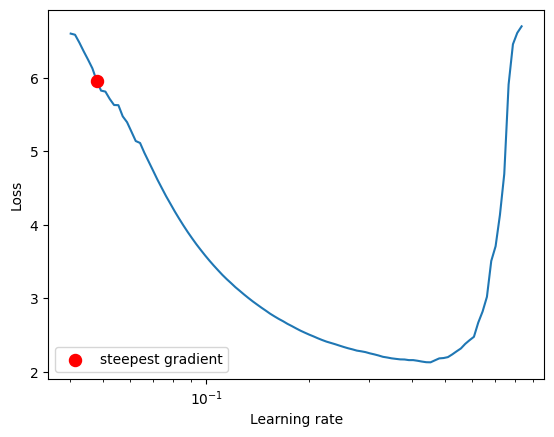

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 0.04785923770503283)

In [20]:
import os
import torch
from src import data_setup, engine, custom_resnet, utils
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import transforms
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt




torch.manual_seed(1)

# Setup hyperparameters
NUM_EPOCHS = 24
BATCH_SIZE = 512
LEARNING_RATE = 0.03
MOMENTUM = 0.9
MAX_LR = 5.22E-02
WEIGHT_DECAY = 1e-4

# Setup directories
train_dir = "../data"
test_dir = "../data"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
# Train Phase transformations
train_transforms = A.Compose([
    #A.HorizontalFlip(),
    #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, p=0.5),
    #A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=(0.49139968, 0.48215827, 0.44653124), mask_fill_value=None),  # Apply coarse dropout
    A.Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768]),  # Normalize the image
    ToTensorV2() # Convert image to a PyTorch tensor
])


# Test Phase transformations
test_transforms = A.Compose([
    A.Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[0.24703233, 0.24348505, 0.26158768]),  # Normalize the image
    ToTensorV2()  # Convert image to a PyTorch tensor
])


# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    batch_size=BATCH_SIZE
)

# Create model with help from custom_resnet.py
model = custom_resnet.CustomResNet().to(device)

# Set loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dataloader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
